In [1]:
__author__ = 'uak211'
import os
import requests
import json
import io
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pylab as plt      
from geopandas import GeoDataFrame, sjoin
from fiona.crs import from_epsg
import shapely
import pysal as ps

/Applications/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams.update({'font.size': 14})

#### downloading the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and reading it in with geopandas

url: https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

In [3]:
### uncomment to download data for the first time ###
# url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
# r = requests.get(url)
# zipref = zipfile.ZipFile(io.BytesIO(r.content), 'r')
# zipref.extractall(os.getenv('PUIDATA'))
# zipref.close()

In [4]:
shpfile = 'geo_export_0665f522-72ea-4a7a-8f30-7e0d4c64e829.shp'
shp = GeoDataFrame.from_file('{}/{}'.format(os.getenv('PUIDATA'), shpfile))
shp.crs = from_epsg(4326)
shp['puma'] = pd.to_numeric(shp['puma'])
shp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [5]:
shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
puma          55 non-null int64
shape_area    55 non-null float64
shape_leng    55 non-null float64
geometry      55 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


#### plotting the PUMA NYC regions

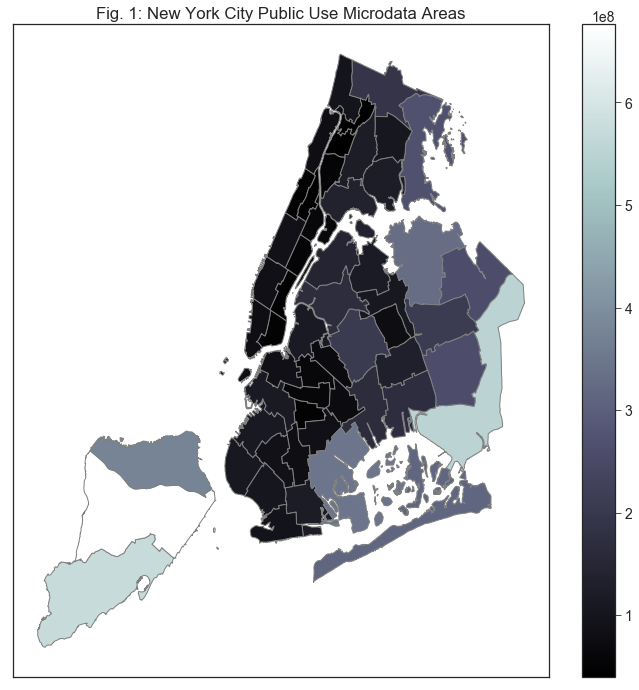

In [6]:
fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
shp.plot(column = 'shape_area', ax = ax, cmap = 'bone', edgecolor = 'gray', legend = True)
plt.title('Fig. 1: New York City Public Use Microdata Areas')
plt.show()

Fig 1: choropleth map showing area in internal units squared of the 55 New York City public use microdata areas 

#### getting data with American Fact Finder (AFF) API: 

In [7]:
# printing out acs 1-year estimate variables 
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
r = requests.get(url)
aff1y = json.loads(r.text)

In [8]:
# set api key
apikey = os.getenv('CENSUSKEY')

In [9]:
# extracting variables of B28002 that contain the string'broadband'
affkeys = np.array(list(aff1y['variables'].keys()))
[(k, aff1y['variables'][k]['label']) for k in affkeys if k.startswith ('B28002') and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [10]:
# keyword for the estimated number of households
households = 'B28002_001E'
aff1y['variables'][households]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [11]:
# keyword for the estimated number of households with broadband access of any type
broadband = 'B28002_004E'
aff1y['variables'][broadband]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [12]:
# getting data on broadband access households via API
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + broadband +\
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + apikey
r = requests.get(url).content
broadband = pd.read_csv(io.StringIO(r.decode('utf-8').replace('[','').replace(']','')))

In [13]:
broadband.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
# getting the total number of households
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + households +\
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + apikey
r = requests.get(url).content
households = pd.read_csv(io.StringIO(r.decode('utf-8').replace('[','').replace(']','')))

In [15]:
households.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


#### generating a feature for the percentage of households with broadband access

In [16]:
for df in (households, broadband):
    df.drop(df.columns[[-1]], axis = 1, inplace = True)

In [17]:
broadband = broadband.merge(households, on = ['NAME', 'state', 'public use microdata area'])
broadband.rename(columns = {'B28002_001E':'total_households', 'B28002_004E':'broadband_households'}, inplace = True)
broadband['pct_bb'] = (broadband.broadband_households / broadband.total_households) * 100
broadband.head(15)

,broadband_households,NAME,state,public use microdata area,total_households,pct_bb
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656
5,32221,"Otsego, Schoharie, Oneida (South) & Herkimer (...",36,403,42081,76.568998
6,41386,"Jefferson & Lewis Counties PUMA, New York",36,500,50860,81.372395
7,37692,"Oswego County PUMA, New York",36,600,44633,84.448726
8,37719,"Onondaga County (Central)--Syracuse City PUMA,...",36,701,56295,67.002398
9,40309,"Onondaga County (North) PUMA, New York",36,702,47988,83.998083


#### comparing above percentages with aff broadband percentage table

In [18]:
### unomment if downloading zip file for first time ###
# zipref = zipfile.ZipFile('{}/aff_download.zip'.format(os.getenv('PUIDATA')), 'r')
# zipref.extractall(os.getenv('PUIDATA'))
# zipref.close()
gct2801 = pd.read_csv('{}/ACS_17_1YR_GCT2801.ST50_with_ann.csv'.format(os.getenv('PUIDATA')), skiprows = [0])
pd.to_numeric(gct2801['Target Geo Id2'])
gct2801['Target Geo Id2'] = gct2801['Target Geo Id2'] - 3600000
gct2801.head(15)

,Id,Id2,Geography,Target Geo Id,Target Geo Id2,Geographic Area,Geographic Area.1,Percent,Margin of Error
0,0400000US36,36,New York,0400000US36,-3599964,New York,New York,83.4,0.2
1,0400000US36,36,New York,7950000US3600100,100,New York - St. Lawrence County PUMA,St. Lawrence County PUMA,82.6,2.4
2,0400000US36,36,New York,7950000US3600200,200,"New York - Clinton, Franklin, Essex & Hamilton...","Clinton, Franklin, Essex & Hamilton Counties PUMA",79.9,2.1
3,0400000US36,36,New York,7950000US3600300,300,New York - Warren & Washington Counties PUMA,Warren & Washington Counties PUMA,82.1,2.4
4,0400000US36,36,New York,7950000US3600401,401,New York - Herkimer (North & Central) & Oneida...,Herkimer (North & Central) & Oneida (Outer) Co...,81.4,2.6
5,0400000US36,36,New York,7950000US3600402,402,New York - Oneida County (Central)--Greater Ut...,Oneida County (Central)--Greater Utica & Rome ...,80.4,2.3
6,0400000US36,36,New York,7950000US3600403,403,"New York - Otsego, Schoharie, Oneida (South) &...","Otsego, Schoharie, Oneida (South) & Herkimer (...",78.2,2.7
7,0400000US36,36,New York,7950000US3600500,500,New York - Jefferson & Lewis Counties PUMA,Jefferson & Lewis Counties PUMA,84.4,2.7
8,0400000US36,36,New York,7950000US3600600,600,New York - Oswego County PUMA,Oswego County PUMA,86.6,2.5
9,0400000US36,36,New York,7950000US3600701,701,New York - Onondaga County (Central)--Syracuse...,Onondaga County (Central)--Syracuse City PUMA,69.5,2.8


#### checking that the percentage of households with broadband api data and aff table data are the same

In [19]:
diff_ = broadband.merge(gct2801, right_on = "Target Geo Id2", left_on = "public use microdata area")[['pct_bb', 'Percent']]
diff_['diff'] = diff_['Percent'].astype(float) - np.abs(diff_['pct_bb']) 
diff_.describe()

,pct_bb,Percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,83.501379,1.655901
std,7.063369,6.487070,3.110461
min,54.932945,57.000000,-8.716747
25%,77.770257,79.800000,0.070230
50%,82.826141,84.200000,1.631002
75%,87.305077,88.300000,3.364335
max,93.404143,95.300000,11.689985


maxiumum percentage difference is 11.69

#### merging with the puma geodataframe and plotting a choropleth of the percentage of households with broadband access

In [20]:
shp = shp.merge(broadband, right_on = 'public use microdata area', left_on = 'puma')
shp.head()

,puma,shape_area,shape_leng,geometry,broadband_households,NAME,state,public use microdata area,total_households,pct_bb
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


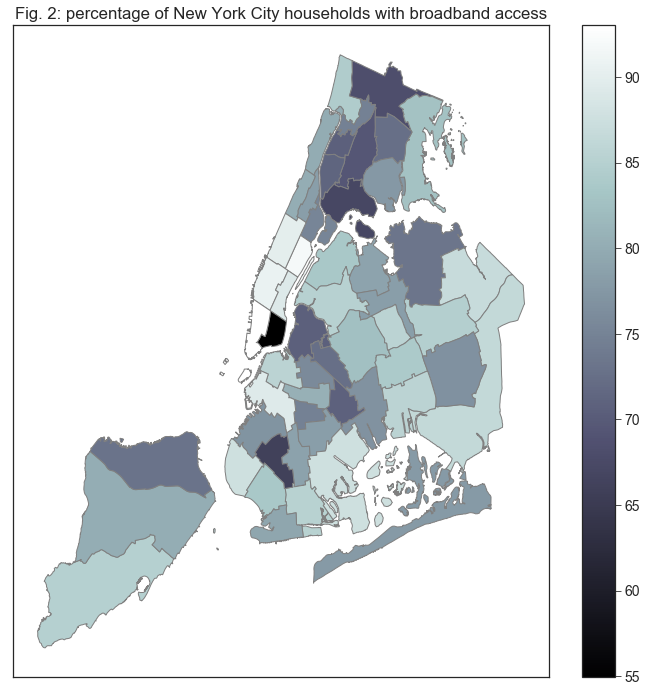

In [21]:
fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
shp.plot(column = 'pct_bb', ax = ax, cmap = 'bone', edgecolor = 'gray', legend = True)
plt.title('Fig. 2: percentage of New York City households with broadband access')
plt.show()

Figure 2: choropleth map of New York City public use microdata areas showing percentage of households with broadband internet access, with lowest percentages found in the Lower East Side and highest percentages found in nearby Financial District.

#### exploring whether the locations of the wifi stations near the areas that need it

In [22]:
# get station location csv
linknyc = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv')
linknyc.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


#### combining lat/long coordinates into geometry and creating geodataframe with linknyc wifi hotspot locations 

In [23]:
geometry = [shapely.geometry.Point(xy) for xy in zip(linknyc.longitude, linknyc.latitude)]
linknyc = linknyc.drop(['longitude', 'latitude'], axis = 1)
linknyc = GeoDataFrame(linknyc, crs = shp.crs, geometry = geometry)
linknyc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 4 columns):
Unnamed: 0    1414 non-null int64
link_site     1414 non-null object
date_link_    1414 non-null object
geometry      1414 non-null object
dtypes: int64(1), object(3)
memory usage: 44.3+ KB


#### plotting the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

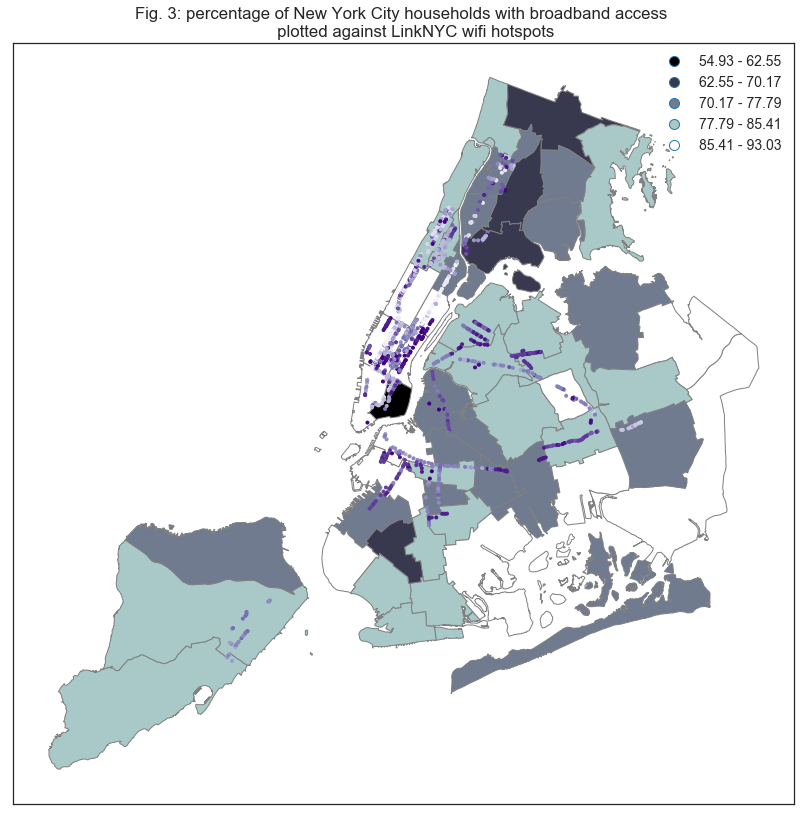

In [24]:
fig, ax = plt.subplots(figsize = (14, 14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Fig. 3: percentage of New York City households with broadband access \n \
    plotted against LinkNYC wifi hotspots')
shp.plot(column = 'pct_bb',ax = ax, cmap = 'bone', scheme = 'equal_interval', edgecolor = 'gray', k = 5, legend = True)
linknyc.plot(column = 'date_link_', ax = ax, cmap = 'Purples', marker = '.')
plt.show()

Figure 3: locations of LinkNYC wifi hotspots shows highest hotspot coverage in midtown Manhattan, coexisting with  high household subsciption rates of broadband. Few areas with low broadband subscription rates see LinkNYC wifi coverage.

#### with the AFF API from ACS, getting the total population by puma and merge it into your GeoDF

In [25]:
# getting sample couint of population data and merging it
pop_var = 'B00001_001E'
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + pop_var +\
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + apikey
r = requests.get(url).content
pop = pd.read_csv(io.StringIO(r.decode('utf-8').replace('[','').replace(']','')))
shp = shp.merge(pop, on = ['NAME', 'state', 'public use microdata area'])
shp.rename(columns = {'B00001_001E':'total_population'}, inplace = True)
shp.head()

,puma,shape_area,shape_leng,geometry,broadband_households,NAME,state,public use microdata area,total_households,pct_bb,total_population,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,NaN


#### finding the number of station per 100 people per PUMA

In [26]:
# convert geodataframes' crs
for g in (shp, linknyc): 
    g = g.to_crs({'init': 'epsg:2263'})
    
# merge linknyc and puma shapefiles, dropping unnamed cols
link_shp = sjoin(shp, linknyc, how = 'left', op = 'intersects')
link_shp.drop(link_shp.columns[[7, 11, 12, 13]], axis = 1, inplace = True)

In [27]:
# get the number of linknyc stations in each puma
link_shp['puma_link_sites'] = link_shp['link_site'].groupby(link_shp['puma']).transform('count')
link_shp.head(4)

,puma,shape_area,shape_leng,geometry,broadband_households,NAME,state,total_households,pct_bb,total_population,link_site,date_link_,puma_link_sites
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820,1517,bx-08-145850,2017-06-10,1
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015,1959,NaN,NaN,0
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141,1305,NaN,NaN,0
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737,1882,NaN,NaN,0


In [28]:
# linknyc stations per 100 inhabitants
link_shp['linknyc_per_100'] = (link_shp['puma_link_sites'] / link_shp['total_population']) * 100
link_shp['linknyc_per_100'].describe()

count    1432.000000
mean        6.131948
std         5.469333
min         0.000000
25%         1.599016
50%         3.973139
75%        13.247173
max        15.141540
Name: linknyc_per_100, dtype: float64

#### plotting the linkNYC locations on top of a choropleth of wifi hotspots per 100 people  in 10 equal intervals


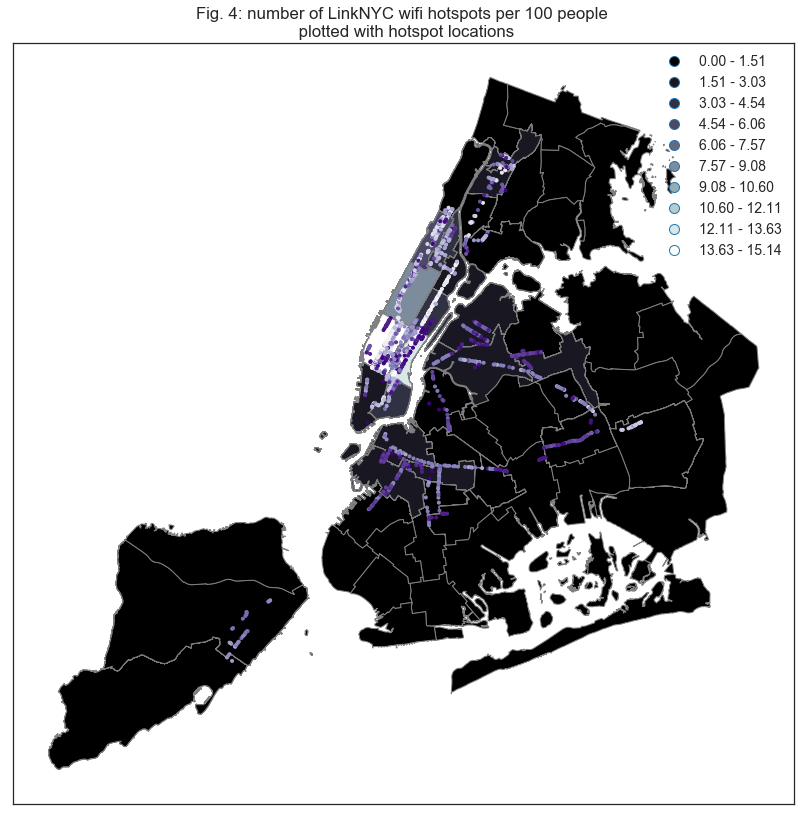

In [35]:
fig, ax = plt.subplots(figsize = (14, 14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Fig. 4: number of LinkNYC wifi hotspots per 100 people \n plotted with hotspot locations')
link_shp.plot(column = 'linknyc_per_100',ax = ax, cmap = 'bone', scheme = 'equal_interval', \
              edgecolor = 'gray', k = 10, legend = True)
linknyc.plot(column = 'date_link_', ax = ax, cmap = 'Purples', marker = '.')
plt.show()

Figure 4: choropleth map of the number of LinkNYC wifi hotspots per 100 people (in deciles) shows midtown and uptown Manhattan have the best coverage, with no other boroughs showing coverage exceeding 4.54 hotspots per 100 people.

#### extra credit 1: 
enhancing the visibility of this map by log transforming the hotspots/100 people variable

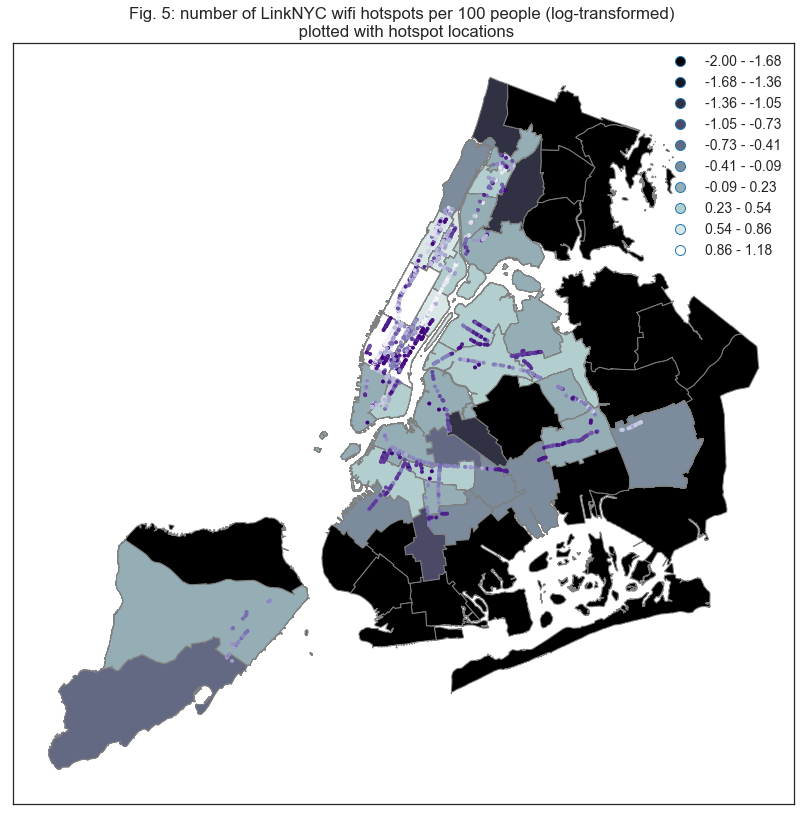

In [30]:
# plotting log base 10 of wifi hotspots per 100 people to improve visibility
link_shp['loglink_per_100'] = np.log10(link_shp['linknyc_per_100'] + 0.01)
fig, ax = plt.subplots(figsize = (14, 14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Fig. 5: number of LinkNYC wifi hotspots per 100 people (log-transformed) \n plotted with hotspot locations')
link_shp.plot(column = 'loglink_per_100', ax = ax, cmap = 'bone', scheme = 'equal_interval', \
              edgecolor = 'gray', k = 10, legend = True)
linknyc.plot(column = 'date_link_', ax = ax, cmap = 'Purples', marker = '.')
plt.show()

Figure 5: choropleth map of the $\log_{10}$-transformed number of LinkNYC wifi hotspots per 100 people in public use microdata areas. The lightest areas appear in midtown Manhattan, with coverage getting progressively sparser further out from Manhattan.

#### extra credit 2:
plotting spatial lag deciles that describe total internet access per public use microdata area by taking the product of the percentage of the population subscribing to broadband and the area's share of the overall number of LinkNYC wifi hotspots.

similarity of pumas are measured with spatial lag:
$$total access lag = \sum_j w_{i,j} total access metric$$

In [31]:
link_shp['total_access'] = link_shp['pct_bb']*(link_shp['puma_link_sites'] / link_shp['puma_link_sites'].sum())

# writing out shapefile to load into weights function
path = '{}/link_shp.shp'.format(os.getenv('PUIDATA'))
link_shp.to_file(path)

In [32]:
# loading contiguity weights
qw_ls = ps.queen_from_shapefile(path)

In [33]:
total_access = link_shp.linknyc_per_100
total_access_lag = ps.lag_spatial(qw_ls, total_access)

# create quantiles
total_access_q = ps.Quantiles(total_access, k = 10)
total_access_q

                Quantiles                
 
Lower            Upper              Count
         x[i] <=  0.948               150
 0.948 < x[i] <=  1.421               149
 1.421 < x[i] <=  1.705               120
 1.705 < x[i] <=  2.379               173
 2.379 < x[i] <=  3.973               184
 3.973 < x[i] <=  5.753               142
 5.753 < x[i] <=  8.048               120
 8.048 < x[i] <= 13.247               164
13.247 < x[i] <= 15.142               230

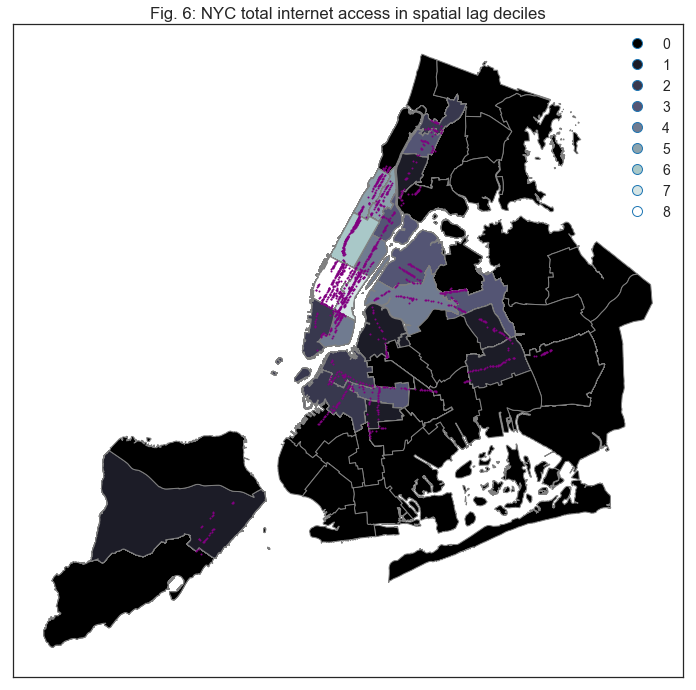

In [34]:
fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Fig. 6: NYC total internet access in spatial lag deciles')
link_shp.assign(cl = total_access_q.yb).plot(column = 'cl', categorical = True, 
         cmap = 'bone', ax = ax, edgecolor = 'gray', legend = True)
linknyc.plot(ax = ax, color = 'purple', markersize = 1)

Figure 6: spatial lag deciles of total internet access across NYC public use microdata areas show total broadband internet access is concentrated in Manhattan, North Brooklyn, and Northern Queens. This concentration owes to the clustered locations of LinkNYC hotspots and the tendency of neighboring public use microdata areas to have similar broadband subscription rates.